In [25]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 
from pyro_oed_src import nmc_eig
from pyro.contrib.util import lexpand

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [8]:
# thresholds for measuring data
designs = torch.tensor([0,2,4,6,8,10], device=device).reshape((6,1))

In [87]:
lexpand(designs,100).shape[:-1]

torch.Size([100, 6])

In [105]:
lam_0 = torch.tensor(0.0, device=device)
lam_1 = torch.tensor(10.0, device=device)

def model(d):
    samples = []
    d = lexpand(n, d)
    with pyro.plate_stack("plate", d.shape[:-1]): 
        theta = pyro.sample("theta", dist.Uniform(lam_0,lam_1))
        m = pyro.sample("m", dist.Poisson(theta))
        samples.append(m)
    return pyro.param("y", torch.sum(torch.stack(samples).squeeze() >= d.squeeze(-1), dim=0, dtype=torch.float32))

In [106]:
model(lexpand(designs,100))

tensor([100.,  76.,  66.,  42.,  27.,  12.], device='cuda:0',
       requires_grad=True)

In [107]:
n = 40000
m = np.sqrt(n).astype(int)
nmc_eig_output_low, nmc_eig_output_high = nmc_eig(model, designs, ["y"], ["theta"], N=n, M=m, contrastive=True)

KeyError: 'log_prob'

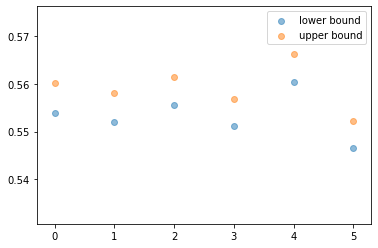

In [69]:
plt.scatter(range(len(designs)), nmc_eig_output_low.cpu(), alpha=0.5, label="lower bound")
plt.scatter(range(len(designs)), nmc_eig_output_high.cpu(), alpha=0.5, label="upper bound")
plt.legend()
plt.show()

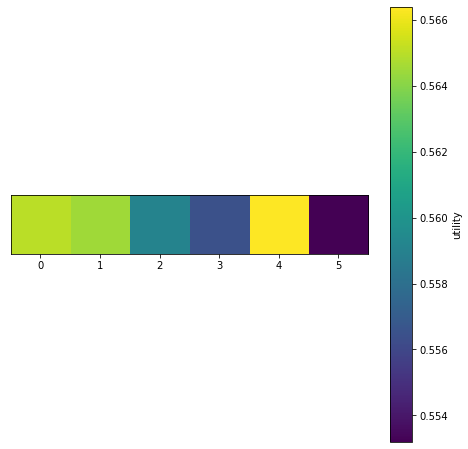

In [22]:
plt.figure(figsize=(8,8))
img_2D = plt.imshow(nmc_eig_output_high.cpu().detach().numpy().reshape(1,6), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.yticks([])
plt.show()